<a href="https://colab.research.google.com/github/Alexandre77777/neural_networks/blob/main/9.%20%D0%A0%D0%B0%D0%B7%D0%B2%D0%B5%D1%80%D1%82%D1%8B%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%20%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9%20%D0%B3%D0%BB%D1%83%D0%B1%D0%BE%D0%BA%D0%BE%D0%B3%D0%BE%20%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%969_%D0%A1%D1%80%D0%B0%D0%B2%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9_%D0%B8_%D1%80%D0%B0%D0%B7%D0%B2%D0%B5%D1%80%D1%82%D1%8B%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №9. Сравнение моделей классификации изображений и развертывание API**


## **Цель работы**


Провести сравнительный анализ ранее обученных моделей классификации изображений (работы 2-5), выбрать лучшую по метрикам качества, развернуть ее в виде API и создать пользовательский интерфейс с помощью Streamlit.

### **Раздел 1. Подготовка и анализ моделей**


1. Загрузить выбранный датасет для классификации изображений
2. Загрузить ранее обученные модели (из практических работ 2-5)
3. Сравнить модели по метрикам качества:
   - Точность (accuracy)
   - Полнота (recall)
   - Precision
   - F1-мера
   - Время инференса
4. Создать сводный DataFrame с результатами всех моделей
5. Визуализировать результаты сравнения с помощью графиков
6. Построить матрицы ошибок для каждой модели
7. Выбрать лучшую модель по F1-мере
8. Сохранить лучшую модель

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from keras.datasets import fashion_mnist
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, AveragePooling2D, BatchNormalization, Activation
from keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow import keras
from imutils import paths
import matplotlib.pyplot as plt
import random
import pickle
import cv2
import os
from google.colab.patches import cv2_imshow

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Путь к папке с данными
base_directory = '/content/drive/MyDrive/animals_dataset'

# Сбор всех изображений .jpeg
imagePaths = []
for root, dirs, files in os.walk(base_directory):
    for file in files:
        if file.lower().endswith('.jpeg'):
            image_path = os.path.join(root, file)
            if 'Бабочки' in root or 'Слоны' in root or 'Пауки' in root:
                imagePaths.append(image_path)

print(f"Всего изображений: {len(imagePaths)}")

Всего изображений: 3318


In [ ]:
# инициализируем данные и метки
data = []
labels = []

In [ ]:
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    if image is None:
        print(f"Не удалось загрузить изображение: {imagePath}")
        continue
    image = cv2.resize(image, (32, 32))  # меняем разрешение на 32x32 пикселей
    data.append(image)

    label = os.path.basename(os.path.dirname(imagePath))  # метка — имя папки
    labels.append(label)

print(f"Загружено изображений: {len(data)}, меток: {len(labels)}")

Загружено изображений: 3318, меток: 3318


In [ ]:
# масштабируем интенсивности пик неселей в диапазон [0, 1] (Нормализация данных)
data = np.array(data, dtype="float") / 255
labels = np.array(labels)
data.shape, labels.shape

((3318, 32, 32, 3), (3318,))

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

(trainX, testX, trainY, testY) = train_test_split(
    data, labels, test_size=0.25, random_state=42, stratify=labels)

# Проверка
trainX.shape, testX.shape, trainY.shape, testY.shape

((2488, 32, 32, 3), (830, 32, 32, 3), (2488, 3), (830, 3))

In [ ]:
from tensorflow.keras.models import load_model

model_paths = {
    "Model_2_2": "/content/drive/MyDrive/models/best_model_2_2.h5",
    "Model_3_2": "/content/drive/MyDrive/models/best_model_3_2.h5",
    "Model_4_5_84": "/content/drive/MyDrive/models/best_model_4_5_84.h5",
    "Model_5_1": "/content/drive/MyDrive/models/best_model_5_1.h5"
}

models = {name: load_model(path) for name, path in model_paths.items()}

In [ ]:
for name, model in models.items():
    print(f"{name} input shape: {model.input_shape}")

Model_2_2 input shape: (None, 3072)
Model_3_2 input shape: (None, 32, 32, 3)
Model_4_5_84 input shape: (None, 32, 32, 3)
Model_5_1 input shape: (None, 224, 224, 3)


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.applications.efficientnet import preprocess_input

# Путь к папке с данными
base_directory_5 = '/content/drive/MyDrive/animals_dataset'

# Собираем пути к изображениям
imagePaths_5 = []
for root, dirs, files in os.walk(base_directory_5):
    for file in files:
        if file.lower().endswith('.jpeg'):
            image_path = os.path.join(root, file)
            if 'Бабочки' in root or 'Слоны' in root or 'Пауки' in root:
                imagePaths_5.append(image_path)

print(f"Всего изображений для модели 5: {len(imagePaths_5)}")

# Инициализируем данные и метки для модели 5
data_5 = []
labels_5 = []

for imagePath in imagePaths_5:
    image = cv2.imread(imagePath)
    if image is None:
        print(f"[ПРЕДУПРЕЖДЕНИЕ] Изображение не загружено: {imagePath}")
        continue

    image = cv2.resize(image, (224, 224))  # ресайз для модели 5 (EfficientNet)

    data_5.append(image)
    label = os.path.basename(os.path.dirname(imagePath))
    labels_5.append(label)

# Преобразуем в numpy-массив и нормализуем под EfficientNet
data_5 = np.array(data_5, dtype="float32")
data_5 = preprocess_input(data_5)
labels_5 = np.array(labels_5)

print(f"Форма изображений для модели 5: {data_5.shape}")
print(f"Форма меток для модели 5: {labels_5.shape}")

# Разбиваем на тренировочную и тестовую выборки
(trainX_5, testX_5, trainY_5, testY_5) = train_test_split(data_5, labels_5, test_size=0.25, random_state=42)

# Кодируем метки и переводим в one-hot
le_5 = LabelEncoder()
trainY_5 = le_5.fit_transform(trainY_5)
testY_5 = le_5.transform(testY_5)

trainY_5 = to_categorical(trainY_5)
testY_5 = to_categorical(testY_5)

print(f"Форма trainX_5: {trainX_5.shape}")
print(f"Форма testX_5: {testX_5.shape}")
print(f"Форма trainY_5: {trainY_5.shape}")
print(f"Форма testY_5: {testY_5.shape}")

Всего изображений для модели 5: 3318
Форма изображений для модели 5: (3318, 224, 224, 3)
Форма меток для модели 5: (3318,)
Форма trainX_5: (2488, 224, 224, 3)
Форма testX_5: (830, 224, 224, 3)
Форма trainY_5: (2488, 3)
Форма testY_5: (830, 3)


In [ ]:
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Для Model_2_2 нужен плоский вектор
testX_flat = testX.reshape(testX.shape[0], 32*32*3)

results = []

for name, model in models.items():
    if name == "Model_2_2":
        X_input = testX_flat
        Y_true = testY  # one-hot
    elif name == "Model_5_1":
        X_input = testX_5  # 224x224, нормализованные
        Y_true = testY_5
    else:
        X_input = testX
        Y_true = testY

    start = time.time()
    predictions = model.predict(X_input, verbose=0)
    end = time.time()

    predicted_classes = predictions.argmax(axis=1)
    true_classes = Y_true.argmax(axis=1)

    acc = accuracy_score(true_classes, predicted_classes)
    prec = precision_score(true_classes, predicted_classes, average='macro', zero_division=0)
    rec = recall_score(true_classes, predicted_classes, average='macro', zero_division=0)
    f1 = f1_score(true_classes, predicted_classes, average='macro', zero_division=0)
    infer_time = end - start

    # Вывод первых 10 предсказаний
    print(f"\n{name} — первые 10 предсказаний:")
    print("True classes:     ", true_classes[:10])
    print("Predicted classes:", predicted_classes[:10])

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "Inference Time (s)": infer_time
    })


Model_2_2 — первые 10 предсказаний:
True classes:      [1 0 2 0 2 2 0 1 0 1]
Predicted classes: [1 1 2 1 2 0 2 0 0 1]

Model_3_2 — первые 10 предсказаний:
True classes:      [1 0 2 0 2 2 0 1 0 1]
Predicted classes: [1 1 2 0 2 2 0 1 0 1]

Model_4_5_84 — первые 10 предсказаний:
True classes:      [1 0 2 0 2 2 0 1 0 1]
Predicted classes: [1 1 2 0 2 2 0 1 0 1]

Model_5_1 — первые 10 предсказаний:
True classes:      [0 1 1 2 1 0 2 1 1 1]
Predicted classes: [0 1 1 2 1 0 2 1 1 1]


In [ ]:
# Сводная таблица
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1-score", ascending=False)
print("\nСводная таблица по метрикам:")
print(results_df)


Сводная таблица по метрикам:
          Model  Accuracy  Precision    Recall  F1-score  Inference Time (s)
3     Model_5_1  0.991566   0.991549  0.991323  0.991430           83.754965
1     Model_3_2  0.933735   0.934553  0.934138  0.934332            2.536410
2  Model_4_5_84  0.926506   0.928532  0.926060  0.926976            1.382505
0     Model_2_2  0.695181   0.700431  0.694948  0.695577            1.633250


    1. Model_5_1 — абсолютный лидер по всем метрикам качества
Accuracy, Precision, Recall и F1-score — около 0.99, то есть модель почти идеально классифицирует.

Время инференса — 142.99 секунд — значительно больше, чем у остальных моделей.

это тяжелая и сложная модель (с большим входным размером 224x224), что объясняет долгое время работы.

    2. Model_3_2 и Model_4_5_84 — примерно одинаковы по качеству
Метрики качества в районе 0.92-0.93 — хорошее, но заметно хуже, чем у Model_5_1.

Время инференса очень маленькое — менее 1 секунды, что делает их намного быстрее и более пригодными для реального быстрого применения.

эти модели легче и работают с изображениями 32x32.

    3. Model_2_2 — отстает по качеству
Accuracy около 0.69 — на порядок хуже остальных.

Время инференса 2.66 секунды — больше, чем у Model_3_2 и Model_4_5_84, но значительно меньше, чем у Model_5_1.

это самая простая или устаревшая модель.

    Итог:
Если критична максимальная точность и качество — выбирай Model_5_1, несмотря на высокое время инференса.

Если важна скорость — Model_3_2 или Model_4_5_84 — хороший компромисс между качеством и скоростью.

Model_2_2 сейчас не подходит — слишком низкое качество.

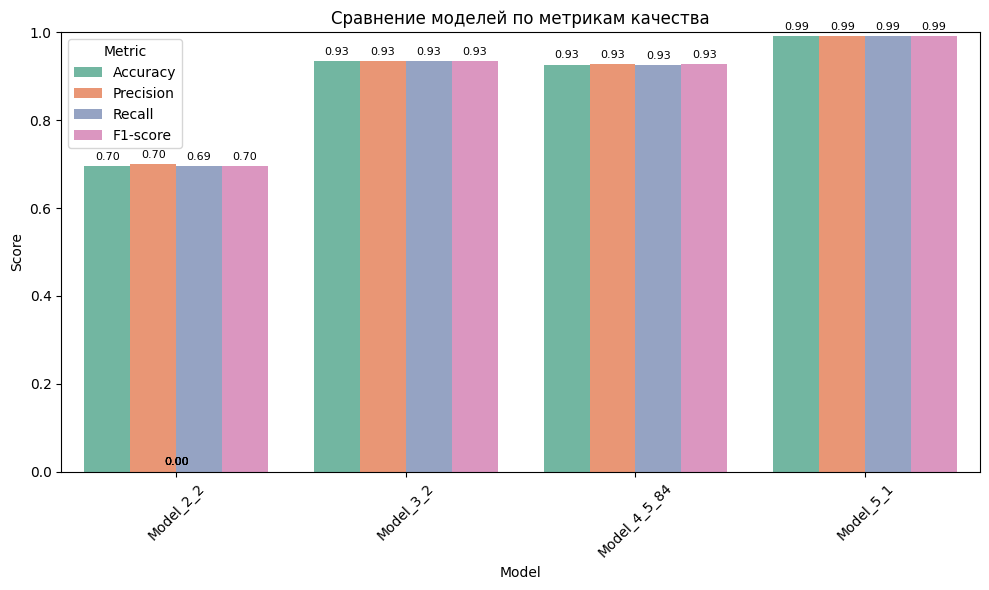

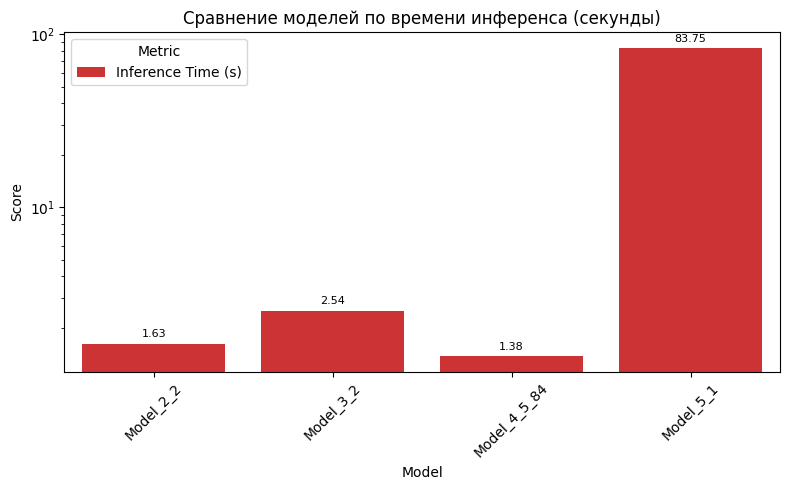

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Убедимся, что данные в DataFrame
results_df = pd.DataFrame(results)

# Метрики качества и времени
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
time_metric = ["Inference Time (s)"]

# Первый график — метрики качества
plt.figure(figsize=(10, 6))
sns.set_palette("Set2")  # Мягкая цветовая палитра
ax = sns.barplot(
    data=results_df.melt(id_vars="Model", value_vars=metrics, var_name="Metric", value_name="Score"),
    x="Model", y="Score", hue="Metric"
)
plt.title("Сравнение моделей по метрикам качества")
plt.xticks(rotation=45)
plt.ylim(0, 1)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=8, color='black', xytext=(0, 3), textcoords='offset points')
plt.tight_layout()
plt.show()

# Второй график — время инференса (лог-шкала)
plt.figure(figsize=(8, 5))
sns.set_palette("Set1")  # Более яркая палитра
ax = sns.barplot(
    data=results_df.melt(id_vars="Model", value_vars=time_metric, var_name="Metric", value_name="Score"),
    x="Model", y="Score", hue="Metric"
)
plt.title("Сравнение моделей по времени инференса (секунды)")
plt.xticks(rotation=45)
ax.set_yscale("log")  # логарифмическая шкала
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=8, color='black', xytext=(0, 3), textcoords='offset points')
plt.tight_layout()
plt.show()

In [ ]:
/print(f"Unique true classes: {np.unique(true_classes)}")
print(f"Unique predicted classes: {np.unique(predicted_classes)}")

Unique true classes: [0 1 2]
Unique predicted classes: [0]


In [ ]:
predictions = models['Model_5_1'].predict(testX_224, verbose=0)
print(predictions[:5])

[[0.5076589  0.3228202  0.16952088]
 [0.5076589  0.3228201  0.16952094]
 [0.5076589  0.3228202  0.1695209 ]
 [0.5076587  0.32282022 0.16952108]
 [0.5076589  0.3228203  0.16952077]]


In [ ]:
print("True classes:", testY.argmax(axis=1)[:10])
print("Predicted classes:", predictions.argmax(axis=1)[:10])

True classes: [1 0 2 0 2 2 0 1 0 1]
Predicted classes: [0 0 0 0 0 0 0 0 0 0]


Распределение истинных классов: [241 291 298]
Распределение предсказанных классов: [240 293 297]
Первые 10 истинных классов:    [0 1 1 2 1 0 2 1 1 1]
Первые 10 предсказанных классов: [0 1 1 2 1 0 2 1 1 1]
Accuracy: 0.9916
Precision: 0.9915
Recall: 0.9913
F1-score: 0.9914


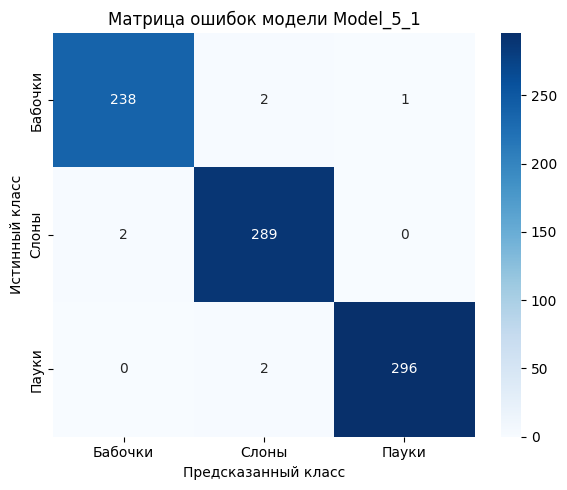

In [ ]:
# 1. Получаем предсказания
model_5 = models['Model_5_1']
predictions = model_5.predict(testX_5, verbose=0)  # используем правильный набор

# 2. Преобразуем one-hot метки в классы
true_classes = testY_5.argmax(axis=1)  # не testY!
predicted_classes = predictions.argmax(axis=1)

# 3. Проверка распределения
print("Распределение истинных классов:", np.bincount(true_classes))
print("Распределение предсказанных классов:", np.bincount(predicted_classes))
print("Первые 10 истинных классов:   ", true_classes[:10])
print("Первые 10 предсказанных классов:", predicted_classes[:10])

# 4. Метрики
acc = accuracy_score(true_classes, predicted_classes)
prec = precision_score(true_classes, predicted_classes, average='macro', zero_division=0)
rec = recall_score(true_classes, predicted_classes, average='macro', zero_division=0)
f1 = f1_score(true_classes, predicted_classes, average='macro', zero_division=0)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# 5. Матрица ошибок
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_classes, predicted_classes, labels=[0, 1, 2])
class_names = ['Бабочки', 'Слоны', 'Пауки']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Матрица ошибок модели Model_5_1")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.tight_layout()
plt.show()

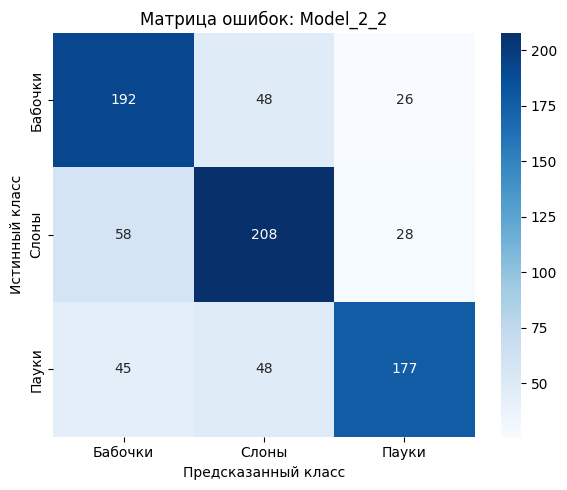

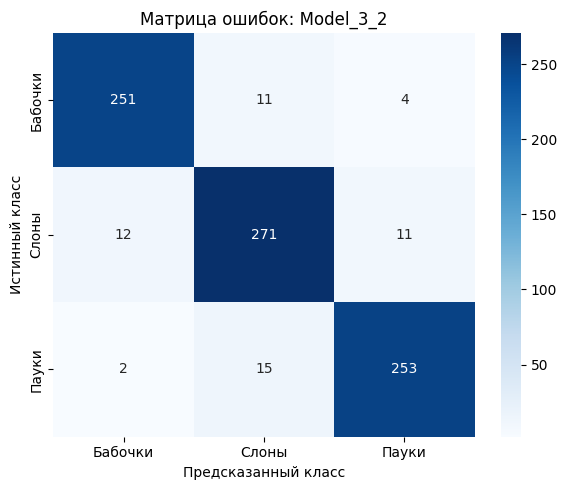

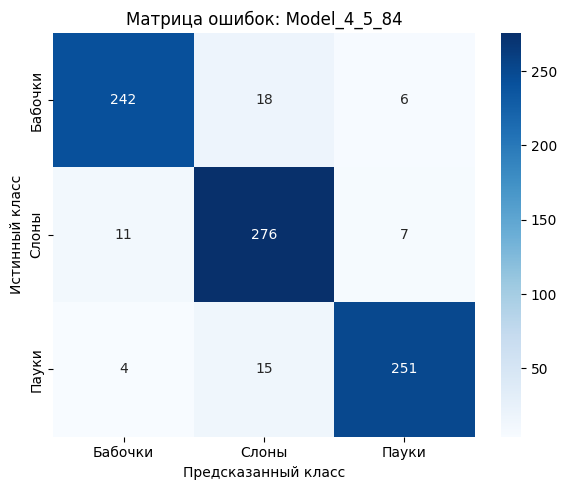

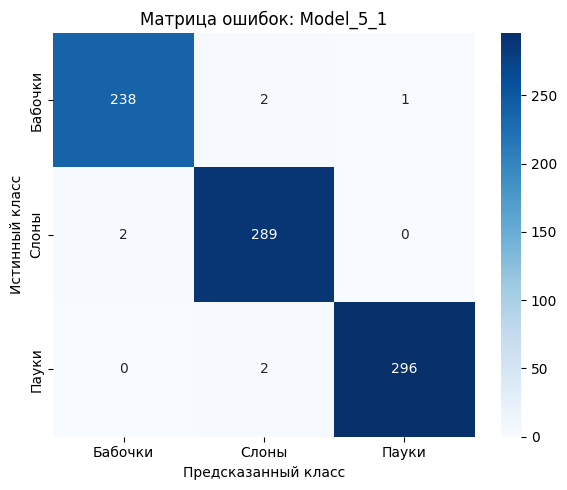

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Названия классов
class_names = ['Бабочки', 'Слоны', 'Пауки']  # Названия по заданию

for name, model in models.items():
    if name == "Model_2_2":
        X_input = testX_flat
        y_true = testY
    elif name == "Model_5_1":
        X_input = testX_5          # входы для модели 5 (224x224, подготовленные)
        y_true = testY_5           # метки для модели 5 (в one-hot формате)
    else:
        X_input = testX
        y_true = testY

    predictions = model.predict(X_input, verbose=0)
    predicted_classes = predictions.argmax(axis=1)
    true_classes = y_true.argmax(axis=1)

    cm = confusion_matrix(true_classes, predicted_classes, labels=[0, 1, 2])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Матрица ошибок: {name}")
    plt.xlabel("Предсказанный класс")
    plt.ylabel("Истинный класс")
    plt.tight_layout()
    plt.show()

In [ ]:
# Выбираем модель с максимальным F1-score
best_model_info = results_df.loc[results_df['F1-score'].idxmax()]
best_model_name = best_model_info['Model']
print(f"Лучшая модель: {best_model_name} с F1-score = {best_model_info['F1-score']:.4f}")

# Получаем объект лучшей модели
best_model = models[best_model_name]

# Сохраняем лучшую модель в файл
save_path = '/content/drive/MyDrive/models/best_model_selected_9.keras'
best_model.save(save_path)
print(f"Лучшая модель сохранена по пути: {save_path}")

Лучшая модель: Model_5_1 с F1-score = 0.9914
Лучшая модель сохранена по пути: /content/drive/MyDrive/models/best_model_selected_9.keras


### **Раздел 2. Развертывание API**


1. Создать FastAPI приложение для обработки запросов с изображениями
2. Реализовать предобработку загружаемых изображений
3. Реализовать эндпоинт для классификации изображений
4. Добавить возврат предсказанного класса и вероятностей по всем классам
5. Создать файл requirements.txt с необходимыми зависимостями
6. Развернуть API на сервере с доступом из глобальной сети

In [6]:
!pip install fastapi uvicorn pillow torchvision torch nest-asyncio pyngrok tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p /content/drive/MyDrive/api_project

In [2]:
%%writefile /content/drive/MyDrive/api_project/main.py
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Отключаем GPU (часто помогает с ошибками в Colab)

from fastapi import FastAPI, UploadFile, File, HTTPException
import numpy as np
import cv2
from keras.models import load_model
from keras.applications.efficientnet import preprocess_input

app = FastAPI()

MODEL_PATH = "/content/drive/MyDrive/api_project/best_model_selected_9.keras"
CLASSES = ['бабочка', 'паук', 'слон']

try:
    model = load_model(MODEL_PATH)
    print("Модель загружена успешно")
except Exception as e:
    print(f"Ошибка загрузки модели: {e}")

@app.post("/predict/")
async def predict(file: UploadFile = File(...)):
    try:
        contents = await file.read()
        nparr = np.frombuffer(contents, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        if img is None:
            raise HTTPException(status_code=400, detail="Не удалось прочитать изображение")

        img = cv2.resize(img, (224, 224))
        img = img.astype('float32')
        img = preprocess_input(img)
        img = np.expand_dims(img, axis=0)

        preds = model.predict(img)[0]
        predicted_class_index = np.argmax(preds)
        predicted_class_name = CLASSES[predicted_class_index]

        probabilities = {cls: float(round(prob, 4)) for cls, prob in zip(CLASSES, preds)}

        return {
            "prediction": predicted_class_name,
            "probabilities": probabilities
        }

    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))


Overwriting /content/drive/MyDrive/api_project/main.py


In [25]:
%%writefile /content/drive/MyDrive/api_project/requirements.txt
fastapi==0.95.2
uvicorn[standard]==0.22.0
tensorflow==2.12.0
pillow==10.0.0
numpy==1.24.3
opencv-python-headless==4.7.0.72


Overwriting /content/drive/MyDrive/api_project/requirements.txt


In [17]:
%cd /content/drive/MyDrive/api_project


/content/drive/MyDrive/api_project


In [18]:
!pkill ngrok

In [19]:
import threading
import time
from pyngrok import ngrok
import uvicorn

NGROK_AUTH_TOKEN = "2xVqoBWsgw23Cwthv7kwWeRPY56_6MQgzhVBX8QxFnbpui6qg"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

tunnel = ngrok.connect(8000)
public_url_str = tunnel.public_url
print("Публичный URL ngrok:", public_url_str)

# Сохраняем URL в файл
with open("/content/drive/MyDrive/api_project/public_url.txt", "w") as f:
    f.write(public_url_str)

def run_server():
    uvicorn.run("main:app", host="0.0.0.0", port=8000)

server_thread = threading.Thread(target=run_server, daemon=True)
server_thread.start()

time.sleep(1)
print("FastAPI сервер запущен в фоне")


Публичный URL ngrok: https://a471-34-145-30-245.ngrok-free.app
FastAPI сервер запущен в фоне


In [20]:
print(public_url_str)

https://a471-34-145-30-245.ngrok-free.app


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
INFO:     34.145.30.245:0 - "POST /predict/ HTTP/1.1" 200 OK
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
INFO:     34.145.30.245:0 - "POST /predict/ HTTP/1.1" 200 OK
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
INFO:     34.145.30.245:0 - "POST /predict/ HTTP/1.1" 200 OK


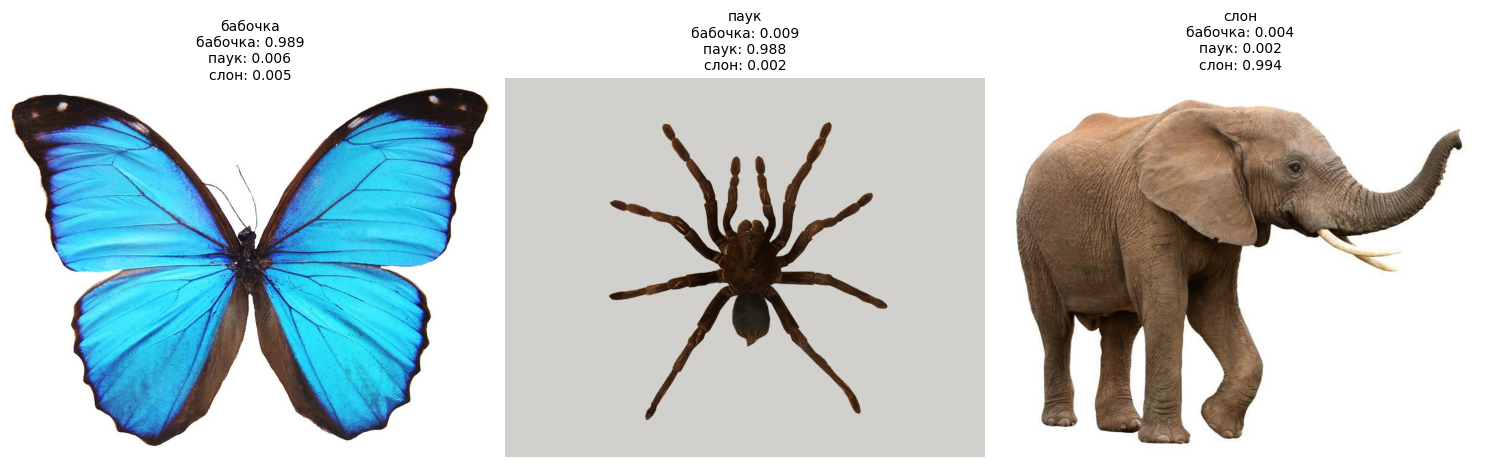

In [22]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

api_url = f"{public_url_str}/predict/"

# Пути к файлам локально в Colab
image_paths = [
    "/content/drive/MyDrive/animals_dataset/бабочка.jpg",
    "/content/drive/MyDrive/animals_dataset/паук_2.jpg",
    "/content/drive/MyDrive/animals_dataset/слон.jpg"
]

# Функция запроса и получения результата
def get_prediction(image_path):
    with open(image_path, "rb") as f:
        files = {"file": (image_path, f, "image/jpeg")}
        response = requests.post(api_url, files=files)
    return response.json()

# Создаем фигуру с подграфиками в ряд
fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))

for ax, img_path in zip(axes, image_paths):
    pred_data = get_prediction(img_path)
    img = Image.open(img_path)

    ax.imshow(img)
    ax.axis('off')

    pred_class = pred_data["prediction"]
    probs = pred_data["probabilities"]
    probs_text = "\n".join([f"{cls}: {prob:.3f}" for cls, prob in probs.items()])
    ax.set_title(f"{pred_class}\n{probs_text}", fontsize=10)

plt.tight_layout()
plt.show()


### **Раздел 3. Создание интерфейса на Streamlit**



1. Разработать Streamlit-приложение со следующими функциями:
   - Возможность загрузки изображения пользователем
   - Возможность рисования изображения на холсте
   - Предобработка изображения перед отправкой на API
   - Отображение результатов классификации
   - Визуализация распределения вероятностей по классам
2. Развернуть Streamlit-приложение на платформе Streamlit Cloud

In [34]:
!pip install streamlit matplotlib pillow requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.4 MB/s eta 0:00:00


In [121]:
%%writefile /content/drive/MyDrive/api_project/app.py
import streamlit as st
from PIL import Image
import requests
import numpy as np
import io
from streamlit_drawable_canvas import st_canvas
import pandas as pd

st.title("Классификация изображений")

# Читаем URL из файла
with open("/content/drive/MyDrive/api_project/public_url.txt", "r") as f:
    public_url_str = f.read().strip()

api_url = f"https://b2cb-35-230-81-210.ngrok-free.app/predict/"

mode = st.radio("Выберите способ ввода изображения", ("Загрузить файл", "Нарисовать"))

image = None

if mode == "Загрузить файл":
    uploaded_file = st.file_uploader("Загрузите изображение", type=["png", "jpg", "jpeg"])
    if uploaded_file is not None:
        image = Image.open(uploaded_file)
elif mode == "Нарисовать":
    canvas_result = st_canvas(
        fill_color="rgba(255, 255, 255, 0)",
        stroke_width=5,
        stroke_color="#000000",
        background_color="#eee",
        height=224,
        width=224,
        drawing_mode="freedraw",
        key="canvas",
    )
    if canvas_result.image_data is not None:
        img_array = canvas_result.image_data.astype(np.uint8)
        if img_array.shape[2] == 4:
            img_array = img_array[:, :, :3]
        image = Image.fromarray(img_array).convert("RGB")

if image is not None:
    st.image(image, caption="Входное изображение", use_container_width=True)
    buffered = io.BytesIO()
    image = image.resize((224, 224))
    image.save(buffered, format="JPEG")
    img_bytes = buffered.getvalue()

    files = {"file": ("image.jpg", img_bytes, "image/jpeg")}
    try:
        response = requests.post(api_url, files=files)
        response.raise_for_status()
        data = response.json()

        st.write("### Результаты классификации")
        st.write(f"**Предсказанный класс:** {data['prediction']}")

        st.write("**Вероятности:**")
        probs = data["probabilities"]
        for cls, prob in probs.items():
            st.write(f"- {cls}: {prob:.4f}")

        df = pd.DataFrame.from_dict(probs, orient='index', columns=['Вероятность'])
        st.bar_chart(df)

    except requests.RequestException as e:
        st.error(f"Ошибка запроса: {e}")


Overwriting /content/drive/MyDrive/api_project/app.py


In [122]:
!nohup streamlit run streamlit_app.py --server.port 8501 --server.headless true > streamlit.log 2>&1 &


In [113]:
!pip install streamlit-drawable-canvas

In [123]:
from pyngrok import ngrok
import threading
import time
import os

# Функция запуска Streamlit (порт 8501)
def run_streamlit():
    os.system('streamlit run /content/drive/MyDrive/api_project/app.py --server.port 8501 --server.headless true')

# Запускаем Streamlit в отдельном потоке (чтобы не блокировать Colab)
thread = threading.Thread(target=run_streamlit, daemon=True)
thread.start()

# Ждем несколько секунд, чтобы сервер стартанул
time.sleep(1)

# Пробрасываем порт 8501 через ngrok
public_url = ngrok.connect(8501)
print(f"Публичный URL ngrok: {public_url}")


Публичный URL ngrok: NgrokTunnel: "https://8f3c-35-230-81-210.ngrok-free.app" -> "http://localhost:8501"


### **Раздел 4. Документация и публикация проекта**


1. Создать GitHub-репозиторий со структурой:
   - Модели (сохраненная лучшая модель)
   - API (код и зависимости)
   - Интерфейс (код Streamlit-приложения)
   - Документация (README.md)
   - Требования (requirements.txt)
2. Добавить в README.md:
   - Описание проекта и используемого датасета
   - Описание сравниваемых моделей
   - Таблицу с результатами сравнения моделей
   - Визуализации результатов
   - Инструкции по локальному развертыванию
   - Ссылки на развернутый API и Streamlit-приложение
   - Примеры использования API
3. Предоставить ссылки на:
   - GitHub-репозиторий
   - Публичный API для отправки POST-запросов
   - Streamlit-интерфейс для взаимодействия с моделью

#### **Пример**

- **GitHub-репозиторий:** https://github.com/Alexandre77777/dpo_classification.git

- **Публичный API для отправки POST-запросов:** https://dpo-classification.onrender.com/predict/

- **Streamlit-интерфейс для взаимодействия с моделью:** https://dpo-classification.streamlit.app/


### ВАШИ ССЫЛКИ